# Text Analytics Group Assignment 2

The data for this assignment is the Yelp Restaurant Review Data. 
This Yelp dataset has information on restaurants (e.g., type of food, price range, etc.) as well as reviews written by patrons. The output variable is the star rating (1-5). It will be best to convert this rating to high (say, ratings of 4 & 5) and low (1, 2, 3). 

### Task A. Ignore the text (reviews) and run a classification model with the numeric data (you can use standard methods like logistic regression, k-nearest neighbors or anything else). What is the best accuracy of your model?

Logistic Regression and KNN performed similarly with test accuracies of 69.5%.

In [81]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import DataFrame
from patsy import dmatrices
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import neighbors
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import scipy.sparse
import matplotlib.pyplot as plt
%pylab inline
import operator
import sklearn.cluster
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
import itertools
import nltk
from operator import itemgetter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
yelp = pd.read_csv("Yelp Data Restaurant Reviews Ratings.csv")

In [6]:
# create output variable 'high'
high_mask = yelp['stars'] > 3
yelp['High'] = 0
yelp.ix[high_mask, 'High'] = 1

In [7]:
train = yelp.sample(int(0.7*len(yelp)),replace=False).copy()
test = yelp[~yelp.index.isin(train.index.values)].copy()

In [8]:
train_x = train.drop(["stars","Review","High"], axis=1).copy()
train_y = train['High']
test_x = test.drop(["stars","Review","High"], axis=1).copy()
test_y = test['High']

In [14]:
# function for accuracy and confusion matrix output
def confusion_matrix(predicted, actual):
    print "Percent Correct\n", round((predicted==actual).mean()*100, 3)
    print "\nConfusion Matrix\n", pd.crosstab(index=actual,columns=predicted)
    print "\nProportion Table\n", pd.crosstab(index=actual,columns=predicted).apply(lambda r: r/r.sum(), axis=1)

####Logistic Regression

In [9]:
logistic_model = LogisticRegression()
logistic_result = logistic_model.fit(train_x, train_y)

In [15]:
logistic_train_prediction = logistic_model.predict(train_x)
confusion_matrix(logistic_train_prediction, train_y) # print training accuracy

Percent Correct
67.891

Confusion Matrix
col_0    0     1
High            
0      233  4328
1      167  9271

Proportion Table
col_0         0         1
High                     
0      0.051085  0.948915
1      0.017694  0.982306


In [16]:
logistic_test_prediction = logistic_model.predict(test_x)
confusion_matrix(logistic_test_prediction, test_y) # print test accuracy

Percent Correct
69.55

Confusion Matrix
col_0    0     1
High            
0      120  1765
1       62  4053

Proportion Table
col_0         0         1
High                     
0      0.063660  0.936340
1      0.015067  0.984933


####KNN

In [13]:
train_accuracies = {}
test_accuracies = {}

for i in range(1, 30, 1): # loop through different values of k
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    knn_result = knn_model.fit(train_x, train_y)
    knn_train_prediction = knn_model.predict(train_x)
    train_accuracies[i] = metrics.accuracy_score(train_y, knn_train_prediction)
    knn_test_prediction = knn_model.predict(test_x)
    test_accuracies[i] = metrics.accuracy_score(test_y, knn_test_prediction)

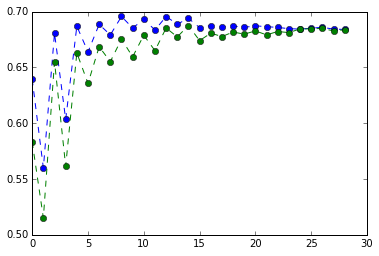

In [12]:
plt.plot(train_accuracies.values(), marker="o", linestyle="--")
plt.plot(test_accuracies.values(), marker="o", linestyle="--")

In [42]:
max(test_accuracies.iteritems(), key=operator.itemgetter(1))[0]

25

In [43]:
train_accuracies[25]

0.69519251375098223

In [44]:
train_accuracies[25]

0.69519251375098223

###Task B. Perform a supervised classification on a subset of the corpus using the reviews only. You can write your code in Python or R. What accuracy do you get from this text mining exercise?

Running Naive Bayes on a random sample of the text data gave us a test accuracy of 68.87%. Seeing that our data is highly imbalanced, we tried undersampling the dataset to ensure a 50/50 split of the classes. This increased accuracy to 80%. Looking at the confusion matrices, we can see that undersampling made the model better at predicting 0's.

####Random Sampling

In [20]:
np.random.seed(1234567)
train = yelp.sample(int(len(yelp)*0.7), replace=False)

In [21]:
test = yelp[~yelp.index.isin(train.index.values)]

In [22]:
train_x = train['Review']
train_y = train['High']
test_x = test['Review']
test_y = test['High']

In [27]:
v = TfidfVectorizer(min_df=0,smooth_idf=True, strip_accents='unicode', norm='l2')

In [28]:
def text_classification():
    x_train = v.fit_transform(train_x)
    x_test = v.transform(test_x)
    
    nb_classifier = MultinomialNB().fit(x_train, train_y)
    train_prediction = nb_classifier.predict(x_train)
    test_prediction = nb_classifier.predict(x_test)
    print("Train:")
    confusion_matrix(train_prediction, train_y)
    print("\nTest:")
    confusion_matrix(test_prediction, test_y)

In [29]:
text_classification()

Train:
Percent Correct
70.526

Confusion Matrix
col_0    0     1
High            
0      368  4124
1        2  9505

Proportion Table
col_0         0         1
High                     
0      0.081923  0.918077
1      0.000210  0.999790

Test:
Percent Correct
68.867

Confusion Matrix
col_0   0     1
High           
0      89  1865
1       3  4043

Proportion Table
col_0         0         1
High                     
0      0.045548  0.954452
1      0.000741  0.999259


####Undersampling data set to ensure 50/50 split

In [36]:
yelp['High'].value_counts() # imbalanced data set

1    13553
0     6446
dtype: int64

In [30]:
highs = yelp[yelp['High']==1]
lows = yelp[yelp['High']==0]

In [31]:
sample_high = highs.sample(len(lows),replace=False).copy()

In [32]:
sample = sample_high.append(lows, ignore_index=True)

In [33]:
train = sample.sample(int(0.7*len(sample)),replace=False).copy()
test = sample[~sample.index.isin(train.index.values)].copy()

In [34]:
train_x = train['Review']
train_y = train['High']
test_x = test['Review']
test_y = test['High']

In [35]:
text_classification()

Train:
Percent Correct
89.351

Confusion Matrix
col_0     0     1
High             
0      4066   405
1       556  3997

Proportion Table
col_0         0         1
High                     
0      0.909416  0.090584
1      0.122117  0.877883

Test:
Percent Correct
80.455

Confusion Matrix
col_0     0     1
High             
0      1643   332
1       424  1469

Proportion Table
col_0         0         1
High                     
0      0.831899  0.168101
1      0.223983  0.776017


###Task C. Combine the numeric data and the text classification model (in task B) to create a “hybrid” model. It is your task to figure out how to do this. Now run this hybrid classification model and compare the results with those in A and B. 

The test accuracy of the hybrid model is 79%, better than the non-text model (69%), but slightly worse than the text model (80%). The hybrid model does a little better than the text model at predicting 1's. 

In [37]:
text_train = v.fit_transform(train_x) # just the reviews
numeric_train = train.drop(["Review", "stars", "High"], axis=1).copy()
numeric_sparse_train = scipy.sparse.csr_matrix(numeric_train.to_sparse())
combined_train = scipy.sparse.hstack([text_train, numeric_sparse_train]) # combining numeric and text

In [38]:
text_test = v.transform(test_x) # repeating above for test
numeric_test = test.drop(["Review", "stars", "High"], axis=1).copy()
numeric_sparse_test = scipy.sparse.csr_matrix(numeric_test.to_sparse())
combined_test = scipy.sparse.hstack([text_test, numeric_sparse_test])

In [40]:
nb_classifier = MultinomialNB().fit(combined_train, train_y)
train_prediction = nb_classifier.predict(combined_train)
test_prediction = nb_classifier.predict(combined_test)
print("Train:")
confusion_matrix(train_prediction, train_y)
print("\nTest:")
confusion_matrix(test_prediction, test_y)

Train:
Percent Correct
87.81

Confusion Matrix
col_0     0     1
High             
0      3905   566
1       534  4019

Proportion Table
col_0         0         1
High                     
0      0.873406  0.126594
1      0.117285  0.882715

Test:
Percent Correct
79.162

Confusion Matrix
col_0     0     1
High             
0      1553   422
1       384  1509

Proportion Table
col_0         0         1
High                     
0      0.786329  0.213671
1      0.202853  0.797147


### Task D. Use unsupervised sentiment analysis on the reviews (with SentiStrength or any other tool) and use the sentiment score to predict high/low rating. Compare and contrast the results of tasks B and D. What can you conclude from your analysis?

The results were poor. The accuracy was 58.47%, which is just slightly better than random guessing. Unsupervised sentiment analysis by itself does not seem to be a good way to predict rating.

In [41]:
sentiment = pd.read_excel("SentiStrength output.xlsx")

C:\Users\Julia Wu\Anaconda\lib\site-packages\xlrd\xlsx.py:246: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.getiterator():
C:\Users\Julia Wu\Anaconda\lib\site-packages\xlrd\xlsx.py:292: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.getiterator():


In [42]:
sentiment['total_sent'] = sentiment['pos_sent'] + sentiment['neg_sent']

In [43]:
sentiment['Actual'] = yelp['High']

In [44]:
pos_sent_mask = sentiment['total_sent'] > 0
sentiment['Predicted'] = 0
sentiment.ix[pos_sent_mask, 'Predicted'] = 1

In [46]:
confusion_matrix(sentiment['Predicted'], sentiment['Actual'])

Percent Correct
58.471

Confusion Matrix
Predicted     0     1
Actual               
0          2354  4092
1          4213  9339

Proportion Table
Predicted         0         1
Actual                       
0          0.365188  0.634812
1          0.310877  0.689123


### Task E. Use unsupervised clustering on the text. Does clustering achieve “good” separation between high and low rated restaurants? How can you explain the result?

Unsupervised clustering did better than unsupervised sentiment analysis with an accuracy of 60%. This makes sense because we used the document term matrix and the type of words people use can be indicative of what they think about the restaurant. Sentiment, on the other hand, can be difficult to gauge.

In [47]:
DTMReviews = v.fit_transform(yelp['Review'])

In [48]:
cluster = sklearn.cluster.KMeans(n_clusters=2, random_state=1)
cluster_out = cluster.fit(DTMReviews)

In [50]:
cluster_out = Series(cluster_out.labels_)

In [63]:
yelp['Cluster_Predicted'] = cluster_out

In [64]:
confusion_matrix(yelp['Cluster_Predicted'], yelp['High'])

Percent Correct
59.823

Confusion Matrix
Cluster_Predicted     0     1
High                         
0                  3521  2925
1                  5110  8443

Proportion Table
Cluster_Predicted         0         1
High                                 
0                  0.546230  0.453770
1                  0.377038  0.622962


### Task F. What are the top 5 “attributes” of a restaurant that are associated with (i) high and (ii) low ratings?

Below we find the top 5 attributes/nouns associated with restaurants with high and low ratings. The attributes discussed are fairly similar regardless of whether it is a high or low rating and consist of things like the 'food', 'place', 'service', and 'restaurant'. It is the words used to describe these nouns that differ. Following what we did in assignment 1, we decided to use log probability ratios to find words that are likely to be found in one class but not the other. Words like 'gem', 'amazing', 'perfect', 'windsor', and 'fantastic' described attributes of restaurants with high ratings and words like 'worse', 'mediocre', 'tasteless', 'worst', and 'terrible' described attributes of restaurants with low ratings.

In [87]:
review_highs = highs['Review']
review_lows = lows['Review']

In [88]:
review_highs = review_highs.str.decode("utf-8")
review_lows = review_lows.str.decode("utf-8")

In [89]:
review_highs = review_highs.map(word_tokenize)
review_lows = review_lows.map(word_tokenize)

In [90]:
review_highs = list(review_highs)
review_lows = list(review_lows)

In [91]:
review_highs = list(itertools.chain.from_iterable(review_highs))
review_lows = list(itertools.chain.from_iterable(review_lows))

In [92]:
highs_lower = [word.lower() for word in review_highs if word.isalpha()]
lows_lower = [word.lower() for word in review_lows if word.isalpha()]

In [93]:
highs_vc = Series(highs_lower).value_counts()
lows_vc = Series(lows_lower).value_counts()

In [94]:
highs_clean = [word for word in highs_vc.index if word not in stopwords.words("english")]
lows_clean = [word for word in lows_vc.index if word not in stopwords.words("english")]

In [95]:
tag_high50 = pos_tag(highs_clean[:50])
tag_low50 = pos_tag(lows_clean[:50])

In [96]:
high_attributes = [word for word, tag in tag_high50 if tag.startswith("NN")]
low_attributes = [word for word, tag in tag_low50 if tag.startswith("NN")]

In [97]:
high_attributes[:5]

[u'food', u'place', u'service', u'menu', u'restaurant']

In [98]:
low_attributes[:5]

[u'food', u'place', u'service', u'restaurant', u'order']

In [79]:
stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")

stop_train_x = stop_vectorizer.fit_transform(train_x)
stop_test_x = stop_vectorizer.transform(test_x)
stop_nb_classifier = MultinomialNB().fit(stop_train_x, train_y)

In [100]:
class0log = stop_nb_classifier.feature_log_prob_[0]
class1log = stop_nb_classifier.feature_log_prob_[1]

class1log_exp = []

for i in class1log:
    class1log_exp.append(math.exp(i))

class0log_exp = []
for j in class0log:
    class0log_exp.append(math.exp(j))

ratio = []
for index, var in enumerate(class1log_exp):
    ratio.append(class0log_exp[index]/var)

vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

bottom5 = np.argsort(ratio)[:5]
print('Words most indicative of a high rating:')
print(" ".join(vocabulary[bottom5]))
top5 = np.argsort(ratio)[-5:]
print('\nWords most indicative of a low rating: ')
print(" ".join(vocabulary[top5]))

Words most indicative of a high rating:
gem amazing perfect windsor fantastic

Words most indicative of a low rating: 
worse mediocre tasteless worst terrible
